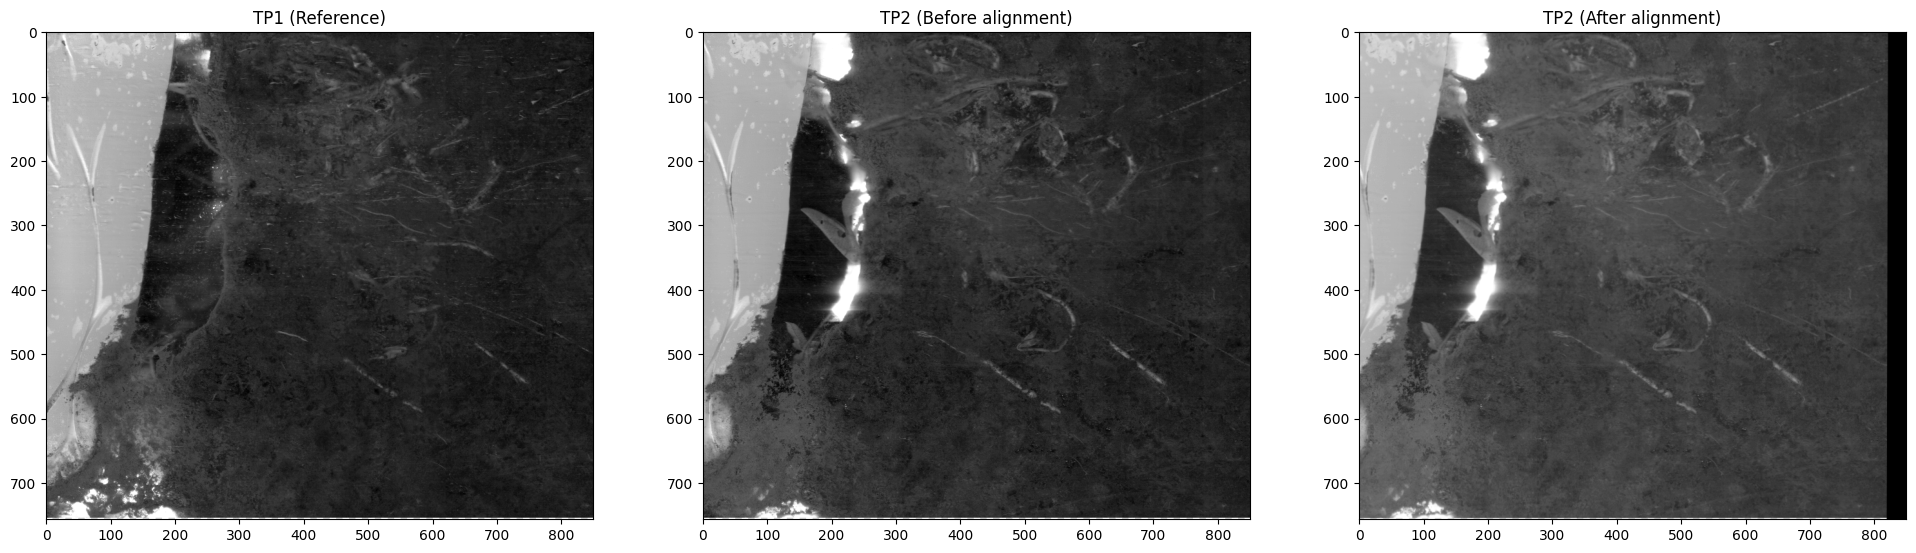

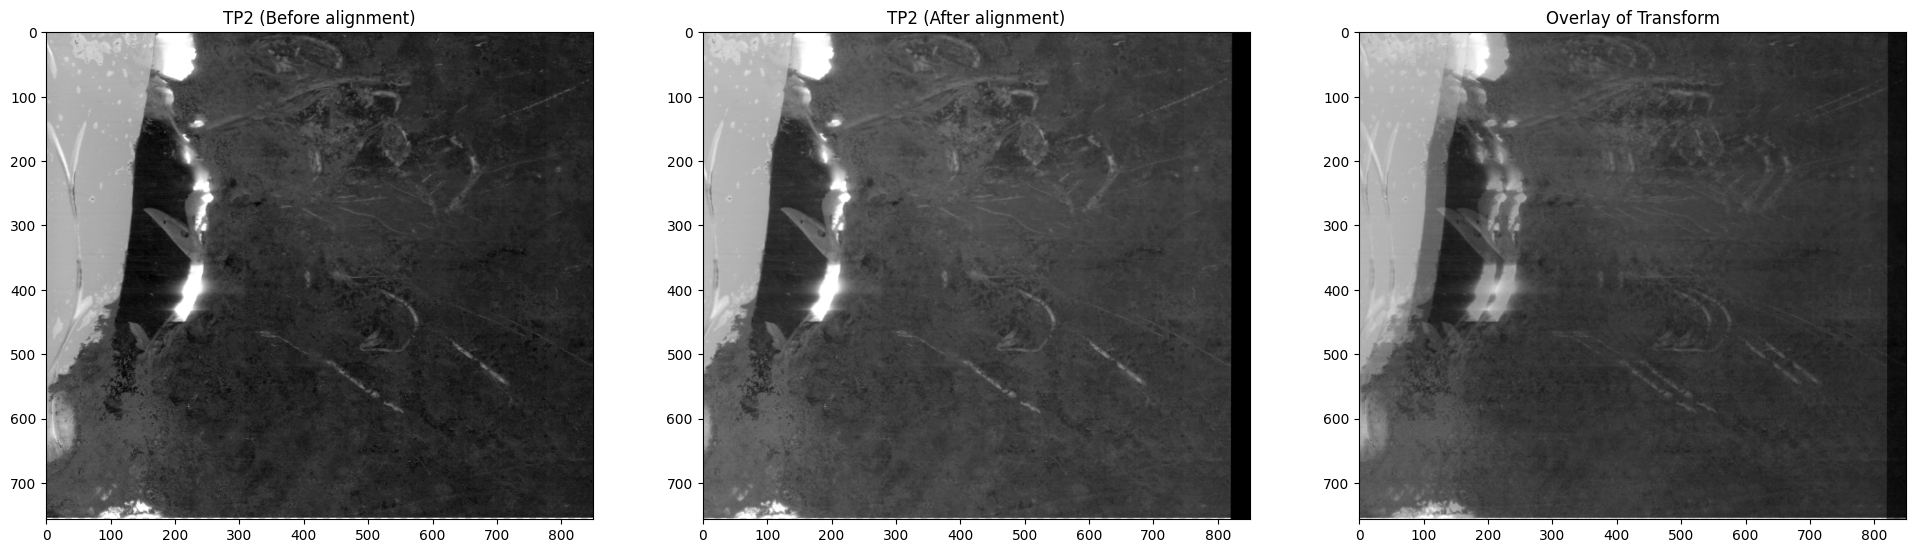

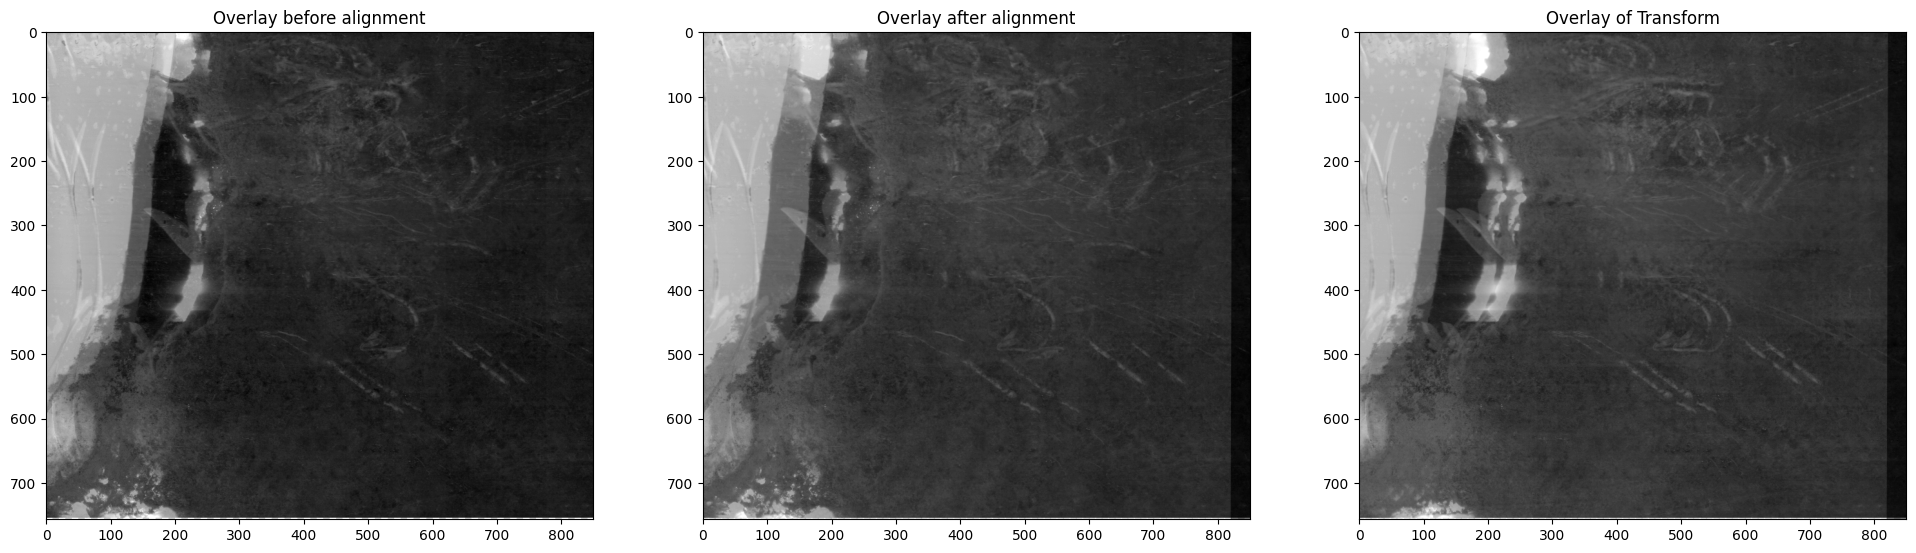

Estimated translation:  (-30.56310134825725, 0.07764047860700884)
Final affine transform:
 [[ 1.0013340e+00 -2.6729207e-03 -3.0573679e+01]
 [-3.6471625e-04  1.0028927e+00 -1.5253942e+00]]


In [31]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# --- Load images ---
# im1 = cv.imread("slu_data/kura_201_001_2024-03-11_TP1.png", cv.IMREAD_GRAYSCALE)
# im2 = cv.imread("slu_data/kura_201_001_2024-03-26_TP2.png", cv.IMREAD_GRAYSCALE)
# im1 = cv.imread("slu_data/kura_201_001_2024-03-26_TP2.png", cv.IMREAD_GRAYSCALE)
# im2 = cv.imread("slu_data/kura_201_001_2024-04-09_TP3.png", cv.IMREAD_GRAYSCALE)
im1 = cv.imread("slu_data/slu_data_201/kura_201_001_2024-04-09_TP3.png", cv.IMREAD_GRAYSCALE)
im2 = cv.imread("slu_data/slu_data_201/kura_201_1_2024-04-22_TP4.png", cv.IMREAD_GRAYSCALE)

# --- Preprocessing ---
def preprocess(img):
    img = cv.GaussianBlur(img, (5, 5), 0)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    return img

I1, I2 = preprocess(im1), preprocess(im2)

# --- Initial translation (phase correlation) ---
# shift, _ = cv.phaseCorrelate(np.float64(I1), np.float64(I2))

# rows, cols = I2.shape
# hamming_window_row = np.hamming(cols)
# hamming_window_col = np.hamming(rows)
# hamming_window_2d = np.outer(hamming_window_col, hamming_window_row)
# shift, _ = cv.phaseCorrelate(np.float64(I1)*hamming_window_2d, np.float64(I2)*hamming_window_2d)

win = cv.createHanningWindow((I1.shape[1], I1.shape[0]), cv.CV_64F)
shift, _ = cv.phaseCorrelate(np.float64(I1)*win, np.float64(I2)*win)

tx, ty = shift
M = np.array([[1, 0, tx], [0, 1, ty]], dtype=np.float32)

# --- Affine refinement with ECC (robust to intensity & small changes) ---
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 200, 1e-6)
warp_mode = cv.MOTION_AFFINE

try:
    cc, M = cv.findTransformECC(I1, I2, M, warp_mode, criteria, None, 5)
except cv.error:
    print("ECC refinement failed; using phase correlation only.")

aligned = cv.warpAffine(im2, M, (im2.shape[1], im2.shape[0]), flags=cv.INTER_LINEAR)

# --- Overlay visualization ---
blend = cv.addWeighted(im1, 0.5, aligned, 0.5, 0)

plt.figure(figsize=(24,12))
plt.subplot(1,3,1); plt.imshow(im1, cmap='gray'); plt.title("TP1 (Reference)")
plt.subplot(1,3,2); plt.imshow(im2, cmap='gray'); plt.title("TP2 (Before alignment)")
plt.subplot(1,3,3); plt.imshow(aligned, cmap='gray'); plt.title("TP2 (After alignment)")
plt.show()

blend_prior = cv.addWeighted(im1, 0.5, im2, 0.5, 0)
blend_transform = cv.addWeighted(im2, 0.5, aligned, 0.5, 0)

plt.figure(figsize=(24,12))
plt.subplot(1,3,1); plt.imshow(im2, cmap='gray'); plt.title("TP2 (Before alignment)")
plt.subplot(1,3,2); plt.imshow(aligned, cmap='gray'); plt.title("TP2 (After alignment)")
plt.subplot(1,3,3); plt.imshow(blend_transform, cmap='gray'); plt.title("Overlay of Transform")
plt.show()

plt.figure(figsize=(24,12))
plt.subplot(1,3,1); plt.imshow(blend_prior, cmap='gray'); plt.title("Overlay before alignment")
plt.subplot(1,3,2); plt.imshow(blend, cmap='gray'); plt.title("Overlay after alignment")
plt.subplot(1,3,3); plt.imshow(blend_transform, cmap='gray'); plt.title("Overlay of Transform")
plt.show()

print("Estimated translation: ", (tx, ty))
print("Final affine transform:\n", M)
